**Table of contents**<a id='toc0_'></a>    
- [Learning a Bayesian Network structure from data](#toc1_)       
  - [Phase 1: Drafting](#toc1_2_)    
  - [Phase 2: Thickening](#toc1_3_)    
  - [Phase 3: Thinning](#toc1_4_)    
- [Test case](#toc2_)    
- [Plotting](#toc3_)    
  - [Classification](#toc3_1_)    
    - [Accuracy](#toc3_1_1_)    
  - [Structure Comparison](#toc3_2_)    
    - [Correlation Score](#toc3_2_1_)    
    - [Log likelihood Score](#toc3_2_2_)    
    - [Graph Edit Distance](#toc3_2_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

---
#  [&#8593;](#toc0_) <a id='toc1_'></a>Learning a Bayesian Network structure from data
### Author: Luca Domeniconi

This is the notebook for the project of FAIKR Module 3 exam at the Master in AI at the University of Bologna.

Here I implemented the algorithm used by *Jie Cheng* in the paper: **Learning Belief Networks from Data: An Information Theory Based Approach** called TPDA. Some subrutines are not in this notebook but in the file ```BuildingBayesianNetwork.py``` to leave the code here as simple as possible.

The algorithm is composed of 3 phases:

1) **Drafting**: here the algorithm computes mutual information of each pair of nodes as a measure of
closeness, and creates a draft based on this information. The draft is a singly connected graph (a graph without loops).
2) **Thickening**: the algorithm adds edges when the pairs of nodes cannot be d-separated. 
3) **Thinning**: each edge of the graph is examined using CI tests and will be removed if the two nodes of the edge can be d-separated. 

In [ ]:
%reload_ext autoreload
%autoreload 2
import networkx as nx
import numpy as np
import BuildingBayesianNetwork as util
import pandas as pd
from sklearn.metrics import mutual_info_score
from tqdm import tqdm
import pgmpy as pgm
from pgmpy.models import BayesianNetwork
import logging
import matplotlib.pyplot as plt
import json
from pgmpy.metrics import correlation_score, structure_score, log_likelihood_score
from sklearn.model_selection import train_test_split

##  [&#8593;](#toc0_) <a id='toc1_2_'></a>Phase 1: Drafting

In the first phase of the algorithm the mutual information is computed for each pair of nodes, and if this value is greater than some small value $\epsilon$ and there is no adjacency path between the two nodes  we add the connection to the graph.
To compute the mutual information we use the following formula:

$$ I(X,Y) = \sum_{y \in Y} \sum_{x \in X} P_{(X,Y)} (x,y) \log \left( \frac{P_{(X,Y)} (x,y)}{ P_X (x) P_Y (y)} \right) $$

where $P_{(X,Y)} (x,y)$ is the joint probability mass function of $X$ and $Y$, and $P_X$ and $P_Y$ are the marginal probability mass functions of $X$ and $Y$.

In [2]:
def drafting(data: pd.DataFrame, epsilon:float) -> tuple[nx.Graph, list]:
    V = data.columns
    G = nx.Graph() # Initialize empty undirected graph
    G.add_nodes_from(V)
    # Create a list with all the nodes pairs whose mutual info is greater than epsilon
    L =[(V[i] ,V[j] , mutual_info_score(data[V[i]],data[V[j]])) for i in range(len(V)) for j in range(i, len(V)) if i != j] 
    L = [(i,j,z) for (i,j,z) in L if z > epsilon]
    
    L.sort(key=lambda x: x[2], reverse=True) # Sort for descending values of mutual information
    # Add the edge between the nodes only if there's no adjacency path between the two
    for x, y, mutual_information in L.copy():
        if not nx.has_path(G, x, y):
            G.add_edge(x, y)
            L.remove((x, y, mutual_information))
    return G, L

##  [&#8593;](#toc0_) <a id='toc1_3_'></a>Phase 2: Thickening

In this phase, edges that can not be d-separated are added in the graph. In the procedure `edge_needed` the conditional mutual information is used with the following formula:

$$ I(X,Y \mid Z) = \sum_{x \in X}\sum_{y \in Y}\sum_{z \in Z} P (x,y,z) \log{\left( \frac{ P(x,y \mid z)}{P(x \mid z) P(y \mid z)} \right)} $$


In [3]:
def thickening(G : nx.Graph, L: list, data: pd.DataFrame, epsilon:float) -> nx.Graph:
    for x, y, _ in L:
        if util.edge_needed(G, x, y, data, epsilon):
            logging.info(f"Adding edge {x} -> {y} to undirected graph")
            G.add_edge(x,y)
    util.clear_cache()
    return G

##  [&#8593;](#toc0_) <a id='toc1_4_'></a>Phase 3: Thinning

In this phase the edges that can be d-separated are removed.

In [4]:
def thinning(G: nx.Graph, data: pd.DataFrame, epsilon:float) -> nx.Graph:
    edges = list(G.edges).copy()
    for x, y in edges:
        G.remove_edge(x, y)
        if nx.has_path(G, x, y):
            if util.edge_needed(G, x, y, data, epsilon):
                G.add_edge(x, y) # If the edge is needed, add it back
            else:
                util.clear_cache()
        else:
            G.add_edge(x, y)
    
    edges = list(G.edges).copy()
    for x,y in edges:
        G.remove_edge(x,y)
        if len(list(G.neighbors(x))) >= 3 or len(list(G.neighbors(y))) >= 3:
            if util.edge_needed(G, x, y, data, epsilon):
                G.add_edge(x, y) # If the edge is needed, add it back
        else:
            G.add_edge(x, y)
            
    util.clear_cache()    
    return G


#  [&#8593;](#toc0_) <a id='toc2_'></a>Test case

Now I test the TPDA algortihm using different metrics such as:
- Classification accuracy
- Correlation score
- Graph edit distance
- Log likelihood score

In [5]:
def TPDA(data: pd.DataFrame, epsilon: float) -> nx.DiGraph:
    G, L = drafting(data, epsilon)
    G = thickening(G, L, data, epsilon)
    G = thinning(G, data, epsilon)
    return G


def evaluate(
    data: pd.DataFrame, true_graph: nx.DiGraph, epsilon: float, test_size: float = 0.3
) -> dict[str, float]:
    """
    returns:
    - correlation score
    - graph edit distance
    - log likelihood score
    """
    # Split the dataset in training and test set
    X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)

    G = TPDA(X_train, epsilon)
    model = util.graph_to_bn(G)
    model.fit(X_train)
    return {
        "correlation_score": correlation_score(
            model, X_test, test="chi_square", significance_level=epsilon
        ),
        "graph_edit_distance": nx.graph_edit_distance(
            G.to_undirected(),
            true_graph.to_undirected(),
            node_match=lambda x, y: x == y,
        ),
        "log_likelihood_score": log_likelihood_score(model, X_test),
    }


def prediction_accuracy(
    data: pd.DataFrame, epsilon: float, target: str, test_size: float = 0.3
) -> float:
    """
    returns:
    - prediction accuracy
    """
    # Split the dataset in training and test set
    X_train, X_test = train_test_split(data, test_size=test_size, random_state=42)

    G = TPDA(X_train, epsilon)
    model = util.graph_to_bn(G)
    model.fit(X_train)

    df_pred = model.predict(X_test.drop(target, axis=1)).values.flatten()
    df_test = X_test[target].values.flatten()
    return (df_pred == df_test).mean()  # Calculate the accuracy

In [6]:
def calculate_correlation(filename: str, epsilons: np.array, test_size: float = 0.3):
    df = pd.read_csv(filename)
    name = filename.split("/")[-1].split(".")[0]

    true_model_nx = util.load_true_model_as_nx(f"data/{name}.bif")
    results = []
    for epsilon in tqdm(epsilons):
        results.append(evaluate(df, true_model_nx, epsilon, test_size=test_size))
    json.dump(results, open(f"./results/{name}_results.json", "w"))


def calculate_accuracy(
    filename: str, epsilons: np.array, target: str, test_size: float = 0.3
) -> list[float]:
    df = pd.read_csv(filename, index_col=0)
    name = filename.split("/")[-1].split(".")[0]

    results = []
    for epsilon in tqdm(epsilons):
        results.append(prediction_accuracy(df, epsilon, target, test_size))
    json.dump(results, open(f"./results/accuracies_{name}.json", "w"))
    return results


Here I test and collect all the results trying different values for $\epsilon$.

In [ ]:
epsilons = 10**(np.linspace(-4, -1, 100)) # Uniformly samples in log space
test_size = 0.3

calculate_correlation("./data/asia.csv", epsilons, test_size=test_size)
calculate_correlation("./data/cancer.csv", epsilons, test_size=test_size)

In [ ]:
epsilons = 10**(np.linspace(-4, -1, 100)) # Uniformly samples in log space
test_size = 0.3

calculate_accuracy('./data/cancer.csv', epsilons, target="Cancer", test_size=test_size)
calculate_accuracy('./data/asia.csv', epsilons, target="bronc", test_size=test_size)
calculate_accuracy('./data/apple_quality_discretized.csv', epsilons, target="Quality", test_size=test_size)
calculate_accuracy('./data/iris_discretized.csv', epsilons, target="target", test_size=test_size)
calculate_accuracy('./data/wine_discretized.csv', epsilons, target="target", test_size=test_size)

#  [&#8593;](#toc0_) <a id='toc3_'></a>Plotting

##  [&#8593;](#toc0_) <a id='toc3_1_'></a>Classification

Here I plot the accuracy for the classification tasks with the following datasets:
- Asia
- Cancer
- Apple
- Iris
- Wine

The classification is made by using as evidence on the Bayesian Network all the attributes, except for the target  and then looking at the CPT of the target value, taking as the result the value with higher probability.

In [23]:
def plot_accuracies(datasets: list,epsilons:list, title: str, xlabel: str, ylabel: str, save_to_pdf = False):
    plt.title(title)
    plt.rcParams['font.size'] = 12
    plt.rcParams['legend.fontsize'] = 9
    # Read the json
    for dataset in datasets:
        values = json.load(open(f'./results/accuracies_{dataset[0]}.json', 'r'))
        plt.plot(np.log10(epsilons), values, label=f"{dataset[0]} dataset", linestyle=dataset[1])
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.legend(loc='lower left')
    if save_to_pdf:
        plt.savefig(f"{title}.pdf", bbox_inches='tight')
    plt.show()

###  [&#8593;](#toc0_) <a id='toc3_1_1_'></a>Accuracy

"Cancer" and "Asia" datasets are plotted differently to highlight the fact that they originally come from a Bayesian Newtork.

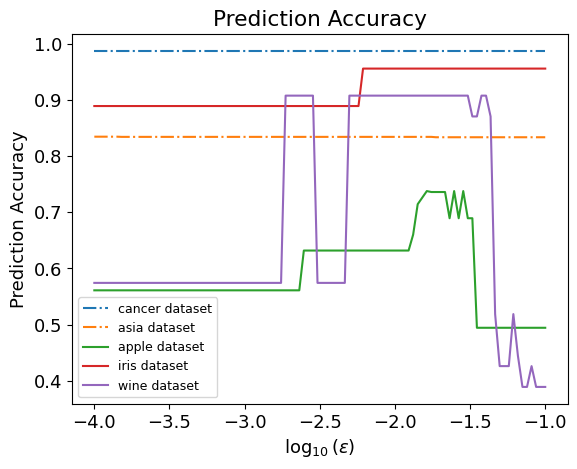

In [24]:
epsilons = 10**(np.linspace(-4, -1, 100)) # Uniformly samples in log space
plot_accuracies([("cancer",'-.'), ("asia",'-.'), ("apple",'-'), ("iris",'-'), ("wine",'-')], epsilons, "Prediction Accuracy", "$\\log_{10}(\\epsilon)$", "Prediction Accuracy", save_to_pdf=True)

##  [&#8593;](#toc0_) <a id='toc3_2_'></a>Structure Comparison

In [30]:
from typing import Literal

def plot_metric(datasets: list,metric: Literal["correlation_score","graph_edit_distance","log_likelihood_score"], epsilons:list, title: str, xlabel: str, ylabel: str, save_to_pdf = False):
    plt.title(title)
    plt.rcParams['font.size'] = 12
    plt.rcParams['legend.fontsize'] = 9
    # Read the json
    for dataset in datasets:
        values = json.load(open(f'./results/{dataset[0]}_results.json', 'r'))
        plt.plot(np.log10(epsilons), [x[metric] for x in values], label=f"{dataset[0]} dataset", linestyle=dataset[1])
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.legend()
    if save_to_pdf:
        plt.savefig(f"{title}.pdf", bbox_inches='tight')
    plt.show()

###  [&#8593;](#toc0_) <a id='toc3_2_1_'></a>Correlation Score

Function to score how well the model structure represents the correlations in the data. The function used is [`correlation_score`](https://pgmpy.org/metrics/metrics.html) from pgmpy using chi square tests.

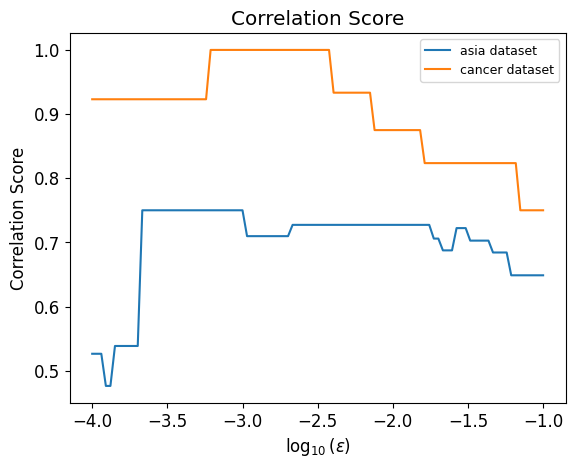

In [31]:
epsilons = 10**(np.linspace(-4, -1, 100)) # Uniformly samples in log space
plot_metric([('asia', '-'), ('cancer', '-')], "correlation_score", epsilons, "Correlation Score", "$\\log_{10}(\\epsilon)$", "Correlation Score", save_to_pdf=True)

###  [&#8593;](#toc0_) <a id='toc3_2_2_'></a>Log likelihood Score

Measures how well the specified model describes the data. The function used is [`log_likelihood_score`](https://pgmpy.org/metrics/metrics.html) from pgmpy.

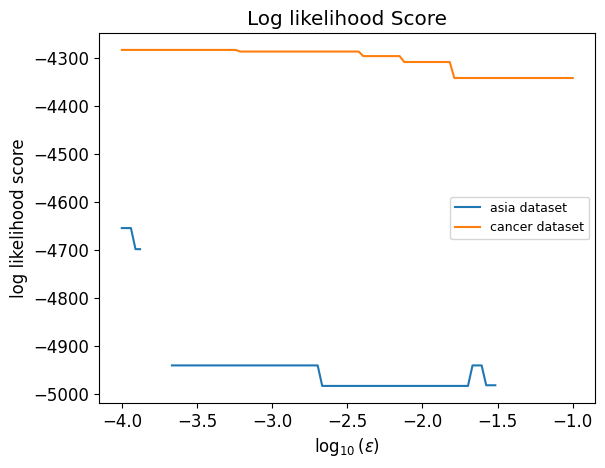

In [32]:
plot_metric([('asia', '-'), ('cancer', '-')], "log_likelihood_score", epsilons, "Log likelihood Score", "$\\log_{10}(\\epsilon)$", "log likelihood score", save_to_pdf=True)

###  [&#8593;](#toc0_) <a id='toc3_2_3_'></a>Graph Edit Distance

Measures how many edges have to be modified in order to match the reconstructed model with the original one. The function used is [`graph_edit_distance`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.similarity.graph_edit_distance.html) from NetworkX.

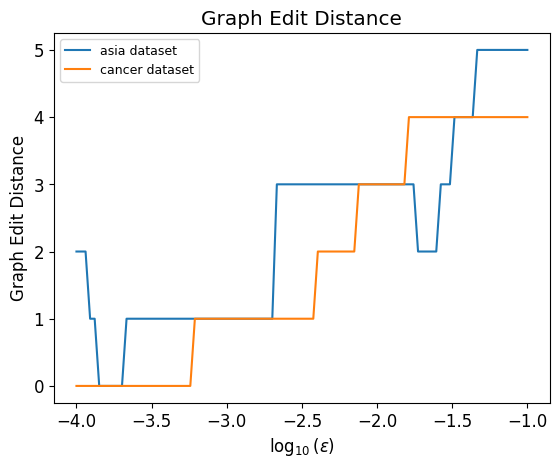

In [33]:
plot_metric([('asia', '-'), ('cancer', '-')], "graph_edit_distance", epsilons, "Graph Edit Distance", "$\\log_{10}(\\epsilon)$", "Graph Edit Distance", save_to_pdf=True)